In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2022-10-25 17:41 (eradiate v0.22.5.post10+g9337c14b.d20221025)*

## The particle layer interface

We start by activating the IPython extension and importing and aliasing a few useful components. We also select the CKD mode.

In [2]:
%load_ext eradiate
import eradiate
import numpy as np
import matplotlib.pyplot as plt
from eradiate.notebook.tutorials import plot_sigma_t

eradiate.set_mode("ckd")

In [3]:
import eradiate.scenes as ertsc
from eradiate import unit_registry as ureg

In [4]:
particle_layer_default = ertsc.atmosphere.ParticleLayer()
particle_layer_default

ParticleLayer(
    id='atmosphere',
    geometry=None,
    scale=None,
    _bottom=0.0 km,
    _top=1.0 km,
    distribution=UniformParticleDistribution(bounds=array([0., 1.])),
    w_ref=550 nm,
    tau_ref=0.2,
    n_layers=16,
    dataset=<xarray.Dataset>
Dimensions:  (w: 20, mu: 181, i: 1, j: 1)
Coordinates:
  * w        (w) float64 350.0 400.0 412.0 443.0 ... 1.95e+03 2.25e+03 3.75e+03
  * i        (i) int64 0
  * j        (j) int64 0
  * mu       (mu) float64 1.0 1.0 1.0 1.0 1.0 ... -0.9983 -0.9993 -0.9998 -1.0
Data variables:
    sigma_t  (w) float64 0.05645 0.04158 0.03882 ... 0.00578 0.005448 0.005256
    albedo   (w) float64 0.9808 0.9798 0.9795 0.9784 ... 0.9129 0.9011 0.8525
    phase    (w, mu, i, j) float64 178.4 173.6 161.7 ... 0.2595 0.2662 0.2686
Attributes:
    convention:  CF-1.8
    title:       Particles radiative properties
    history:     2021-11-03 15:29:43 - data set creation - kata, version 0.0.2,
    _phase=TabulatedPhaseFunction(
        id='phase_atmosphere',
        data=<xarray.DataArray 'phase' (w: 20, mu: 181, i: 1, j: 1)>
array([[[[2.1040000e-01]],

        [[2.1451000e-01]],

        [[2.2864000e-01]],

        ...,

        [[1.6167650e+02]],

        [[1.7361663e+02]],

        [[1.7842933e+02]]],


       [[[2.1991000e-01]],

        [[2.1822000e-01]],

        [[2.2853000e-01]],
...
        [[6.7030030e+01]],

        [[6.7152350e+01]],

        [[6.7193330e+01]]],


       [[[2.6860000e-01]],

        [[2.6621000e-01]],

        [[2.5953000e-01]],

        ...,

        [[3.0493370e+01]],

        [[3.0512870e+01]],

        [[3.0519370e+01]]]])
Coordinates:
  * w        (w) float64 350.0 400.0 412.0 443.0 ... 1.95e+03 2.25e+03 3.75e+03
  * i        (i) int64 0
  * j        (j) int64 0
  * mu       (mu) float64 -1.0 -0.9998 -0.9993 -0.9983 ... 1.0 1.0 1.0 1.0
Attributes:
    standard_name:  scattering_phase_matrix
    long_name:      scattering phase matrix
    units:          str^-1
    )
)

We see that our `particle_layer_default` variable represents an aerosol layer with:

* a vertical extent from 0 to 1 km;
* a uniform particle density distribution within that extent;
* a division into 16 uniform cells;
* an optical thickness at 550 nm equal to 0.2.

We can now visualise the extinction coefficient using the following convenience function:

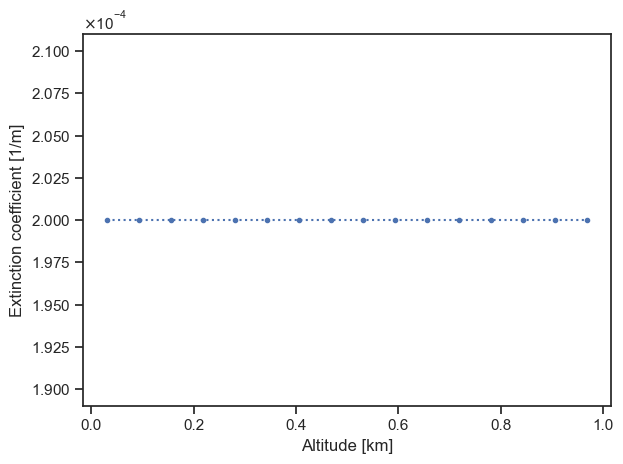

In [5]:
plot_sigma_t(particle_layer_default)

Now, let's define a particle layer with a different optical thickness:

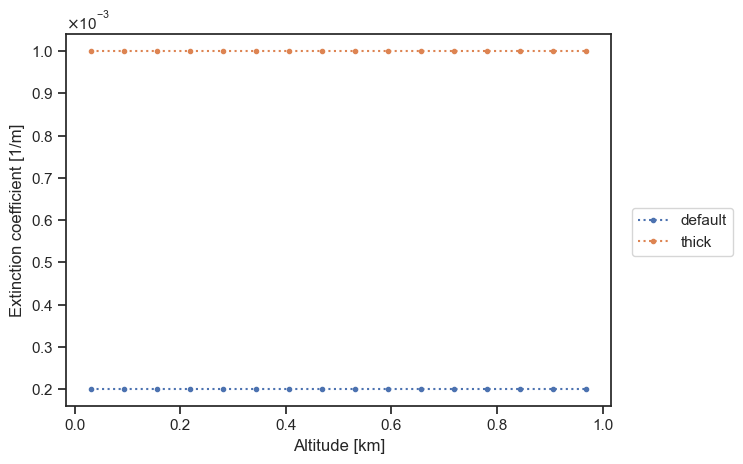

In [6]:
particle_layer_thick = ertsc.atmosphere.ParticleLayer(tau_ref=1.0)
plot_sigma_t(
    particle_layer_default,
    particle_layer_thick,
    labels=["default", "thick"],
)

We can also modify the extent of our particle using the *bottom* and *top* parameters:

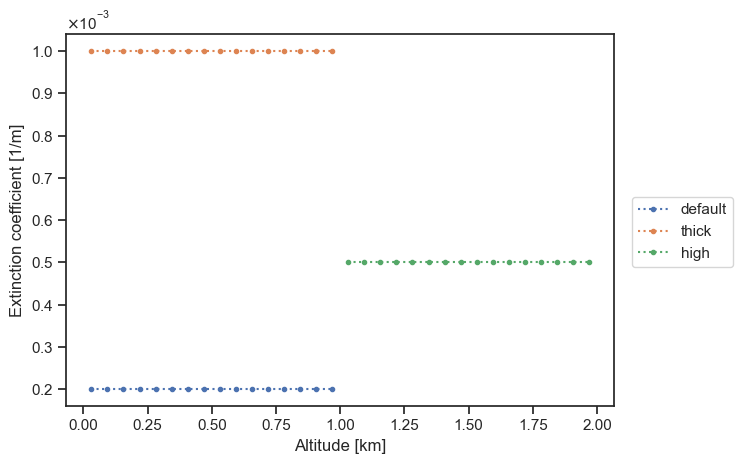

In [7]:
particle_layer_high = ertsc.atmosphere.ParticleLayer(tau_ref=0.5, bottom=1 * ureg.km, top=2 * ureg.km)
plot_sigma_t(
    particle_layer_default,
    particle_layer_thick,
    particle_layer_high,
    labels=["default", "thick", "high"],
)

We can vary the particle density distribution within the defined bounds:

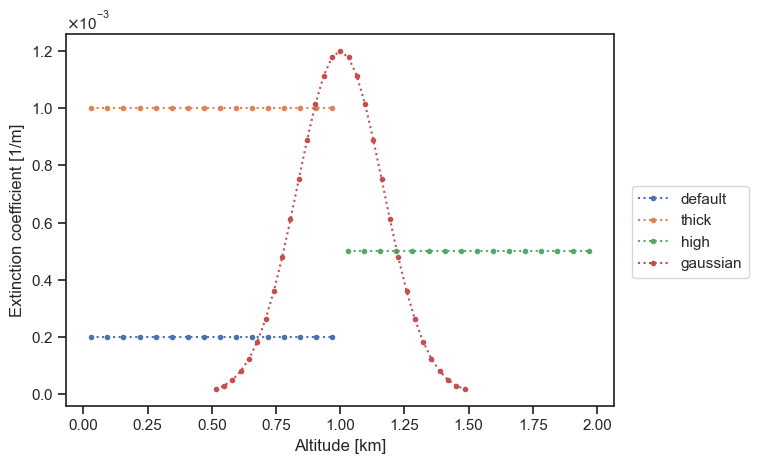

In [8]:
particle_layer_gaussian = ertsc.atmosphere.ParticleLayer(
    tau_ref=0.5,
    bottom=0.5 * ureg.km,
    top=1.5 * ureg.km,
    distribution="gaussian",
    n_layers=31,
)

plot_sigma_t(
    particle_layer_default,
    particle_layer_thick,
    particle_layer_high,
    particle_layer_gaussian,
    labels=["default", "thick", "high", "gaussian"],
)

In [9]:
exponential = ertsc.atmosphere.ParticleLayer(
    tau_ref=0.05, 
    bottom=0 * ureg.km, 
    top=6 * ureg.km,
    distribution="exponential",
)

gaussian = ertsc.atmosphere.ParticleLayer(
    tau_ref=0.02, 
    bottom=1 * ureg.km, 
    top=2 * ureg.km,
    distribution="gaussian",
)

atmosphere = ertsc.atmosphere.HeterogeneousAtmosphere(
    molecular_atmosphere={"type": "molecular"},
    particle_layers=[exponential, gaussian]
)

We can display the extinction coefficient for the full atmospheric profile and all its components as follows (note that we restrict the view range to the [0, 10] km extent for clarity

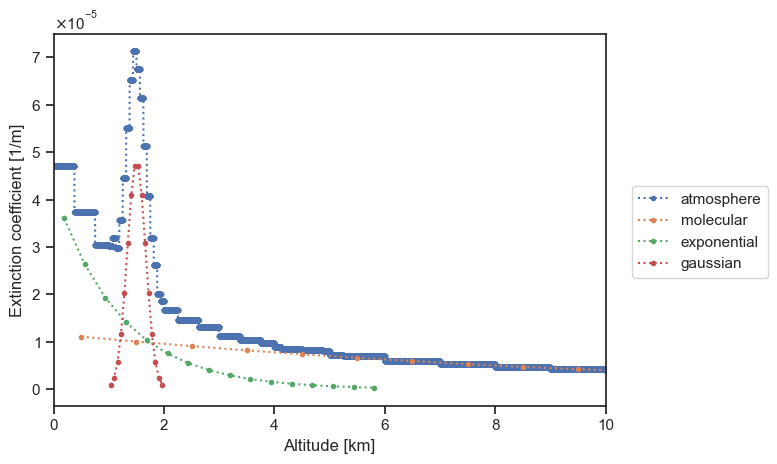

In [10]:
plot_sigma_t(
    atmosphere,
    atmosphere.molecular_atmosphere,
    exponential,
    gaussian,
    labels=["atmosphere", "molecular", "exponential", "gaussian"],
    altitude_extent=(0, 10),
)

## Running the simulation

We can now use this atmosphere definition to run a 1D simulation and compute the top-of-atmosphere BRF:

In [11]:
# Show only spectral loop progress
eradiate.config.progress = "spectral_loop"

exp = eradiate.experiments.AtmosphereExperiment(
    surface={"type": "lambertian", "reflectance": 1.0},
    atmosphere=atmosphere,
    illumination={"type": "directional", "zenith": 30.0, "azimuth": 0.0},
    measures={
        "type": "mdistant",
        "construct": "hplane",
        "zeniths": np.arange(-75, 76, 5),
        "azimuth": 0.0,
        "spectral_cfg": {"bins": ["550"]},  # Run the simulation for the 550 nm bin
        "spp": 10000,
    },
)
result = eradiate.run(exp)
result

0/16|          | 00:00, ETA=?

<xarray.Dataset>
Dimensions: (sza: 1, saa: 1, y_index: 1, x_index: 31, w: 1, srf_w: 1)
Coordinates: (12/13)
 * sza (sza) float64 30.0
 * saa (saa) float64 0.0
 * y_index (y_index) int64 0
 * x_index (x_index) int64 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
 bin (w) object '550'
 y (y_index) float64 0.0
 ... ...
 * w (w) float64 550.0
 bin_wmin (w) float64 545.0
 bin_wmax (w) float64 555.0
 vza (x_index, y_index) int64 -75 -70 -65 -60 -55 ... 60 65 70 75
 vaa (x_index, y_index) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
 * srf_w (srf_w) float64 550.0
Data variables:
 radiance (sza, saa, w, y_index, x_index) float64 0.4122 ... 0.4157
 spp (sza, saa, w) float64 1e+04
 irradiance (sza, saa, w) float64 1.621
 srf (srf_w) float64 1.0
 brdf (sza, saa, w, y_index, x_index) float64 0.2543 ... 0.2565
 brf (sza, saa, w, y_index, x_index) float64 0.7989 ... 0.8057
 radiance_srf (sza, saa, y_index, x_index) float64 0.4122 ... 0.4157
 irradiance_srf (sza, saa) float64 1.621
 brdf_srf (sza, saa, y_index, x_index) float64 0.2543 ... 0.2565
 brf_srf (sza, saa, y_index, x_index) float64 0.7989 ... 0.8057
Attributes:
 convention: CF-1.8
 source: eradiate, version 0.22.5.post10+g9337c14b.d20221025
 history: 2022-10-25 17:42:03 - data creation - AtmosphereExperiment.p...
 references: 
 title: Top-of-atmosphere simulation results xarray.Dataset Dimensions: sza : 1 saa : 1 y_index : 1 x_index : 31 w : 1 srf_w : 1 Coordinates: (13) sza (sza) float64 30.0 standard_name : solar_zenith_angle long_name : solar zenith angle units : deg array([30.]) saa (saa) float64 0.0 standard_name : solar_azimuth_angle long_name : solar azimuth angle units : deg array([0.]) y_index (y_index) int64 0 long_name : height pixel index array([0]) x_index (x_index) int64 0 1 2 3 4 5 6 ... 25 26 27 28 29 30 long_name : width pixel index array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]) bin (w) object '550' standard_name : ckd_bin long_name : CKD bin array(['550'], dtype=object) y (y_index) float64 0.0 long_name : film height coordinate array([0.]) x (x_index) float64 0.0 0.03333 0.06667 ... 0.9667 1.0 long_name : film width coordinate array([0. , 0.03333333, 0.06666667, 0.1 , 0.13333333,
 0.16666667, 0.2 , 0.23333333, 0.26666667, 0.3 ,
 0.33333333, 0.36666667, 0.4 , 0.43333333, 0.46666667,
 0.5 , 0.53333333, 0.56666667, 0.6 , 0.63333333,
 0.66666667, 0.7 , 0.73333333, 0.76666667, 0.8 ,
 0.83333333, 0.86666667, 0.9 , 0.93333333, 0.96666667,
 1. ]) w (w) float64 550.0 standard_name : wavelength long_name : wavelength units : nm array([550.]) bin_wmin (w) float64 545.0 standard_name : bin_wmin long_name : spectral bin lower bound units : nm array([545.]) bin_wmax (w) float64 555.0 standard_name : bin_wmax long_name : spectral bin upper bound units : nm array([555.]) vza (x_index, y_index) int64 -75 -70 -65 -60 -55 ... 60 65 70 75 standard_name : viewing_zenith_angle long_name : viewing zenith angle units : deg array([[-75],
 [-70],
 [-65],
 [-60],
 [-55],
 [-50],
 [-45],
 [-40],
 [-35],
 [-30],
 [-25],
 [-20],
 [-15],
 [-10],
 [ -5],
 [ 0],
 [ 5],
 [ 10],
 [ 15],
 [ 20],
 [ 25],
 [ 30],
 [ 35],
 [ 40],
 [ 45],
 [ 50],
 [ 55],
 [ 60],
 [ 65],
 [ 70],
 [ 75]]) vaa (x_index, y_index) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 standard_name : viewing_azimuth_angle long_name : viewing azimuth angle units : deg array([[0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0]]) srf_w (srf_w) float64 550.0 standard_name : wavelength long_name : wavelength units : nm array([550.]) Data variables: (10) radiance (sza, saa, w, y_index, x_index) float64 0.4122 0.4338 ... 0.4397 0.4157 standard_name : radiance long_name : radiance units : W / m ** 2 / nm / sr array([[[[[0.41217591, 0.43380456, 0.44738282, 0.45617213, 0.46307746,
 0.46929442, 0.47474467, 0.47807829, 0.47964742, 0.48317257,
 0.48645

And we can plot the computed TOA BRF:

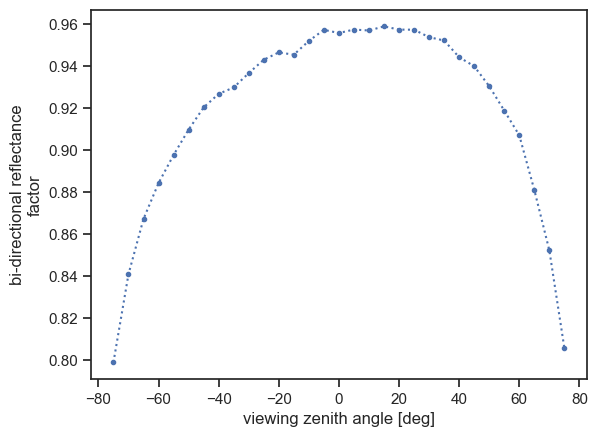

In [12]:
with plt.rc_context({"lines.marker": ".", "lines.linestyle": ":"}):
    result.brf.squeeze(drop=True).plot(x="vza");